Start by making sure all of these libraries are properly available

In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import os
import urllib
import random
import scipy.io as sio
%matplotlib inline
print "Done"

/Users/thalles/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Done


Now, let's ensure that the datasets are properly downloaded.

In [7]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename):
  """Download a file if not present"""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
    print filename, "download completed."
  else:
    print 'Filename:', filename, 'is already downloaded.'
  return filename

# download the datasets if necessary
train_dataset_filename = maybe_download("train_32x32.mat")
test_dataset_filename = maybe_download("test_32x32.mat")
extra_dataset_filename = maybe_download("extra_32x32.mat")

Filename: train_32x32.mat is already downloaded.
Filename: test_32x32.mat is already downloaded.
Filename: extra_32x32.mat is already downloaded.


Load the training, testing and extra datasets.

In [8]:
traning_size = 73257
testing_size = 26032
extra_size = 531131

raw_train_data = sio.loadmat(train_dataset_filename)
raw_test_data = sio.loadmat(test_dataset_filename)
raw_extra_data = sio.loadmat(extra_dataset_filename)

train_dataset, train_labels =  raw_train_data["X"], raw_train_data["y"]
test_dataset, test_labels = raw_test_data["X"], raw_test_data["y"]
extra_dataset, extra_labels = raw_extra_data["X"], raw_extra_data["y"]

# free up memory from the notebook cache
%xdel raw_train_data
%xdel raw_test_data
%xdel raw_extra_data

print "Train dataset shape:", train_dataset.shape
print "Train labels shape:",train_labels.shape
print "Test dataset shape:",test_dataset.shape
print "Test labels shape:",test_labels.shape
print "Extra dataset shape:",extra_dataset.shape
print "Extra labels shape:",extra_labels.shape

Train dataset shape: (32, 32, 3, 73257)
Train labels shape: (73257, 1)
Test dataset shape: (32, 32, 3, 26032)
Test labels shape: (26032, 1)
Extra dataset shape: (32, 32, 3, 531131)
Extra labels shape: (531131, 1)


Display some of the training set images.

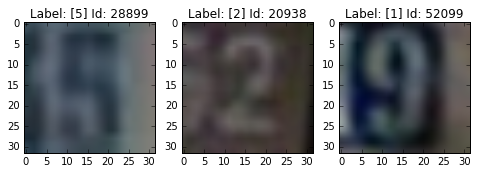

In [9]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,8))

i = random.randrange(0,train_labels.shape[0])
img = train_dataset[:,:,:,i]
ax1.imshow(img, cmap=plt.cm.Greys);
ax1.set_title('Label: ' + str(train_labels[i])+ " Id: " + str(i))

i = random.randrange(0,train_labels.shape[0])
img = train_dataset[:,:,:,i]
ax2.imshow(img, cmap=plt.cm.Greys);
ax2.set_title('Label: ' + str(train_labels[i])+ " Id: " + str(i))

i = 52099
img = train_dataset[:,:,:,i]
ax3.imshow(img, cmap=plt.cm.Greys);
ax3.set_title('Label: ' + str(train_labels[i])+ " Id: " + str(i))

Let's define some constants that will be usefull later on.

In [10]:
BATCH_SIZE=64
IMAGE_SIZE=32
N_CHANNELS=1
NUM_LABELS=10
PIXEL_DEPTH=255
VALIDATION_DATASET_SIZE=5000

Now let's create a histogram that display the image distribution across all the classes. We expect the data to be balanced across classes.  

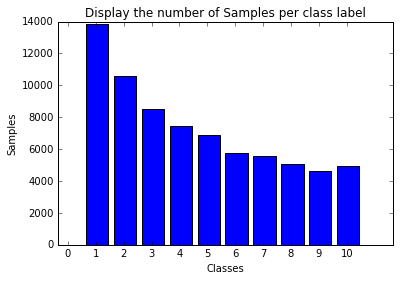

In [11]:
data_distribution = np.bincount(train_labels.reshape(train_labels.shape[0]))
index = np.arange(11)
plt.bar(index, data_distribution)
plt.title("Display the number of Samples per class label")
plt.xlabel('Classes')
plt.ylabel('Samples')

bar_width = 0.35
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

plt.show()

As we can see, the training set distribution of images per class is not well balanced. There are much more images of class label 1 than any other. Indeed, we notice that there are more than twice as much images from class label '1' than from classes labels '0', '6', '7', '8', and '9'. In order to have a relative measure of class imbalance, we can define the Degree of Class Imbalance (DCI) as described in [], as the equation:

\begin{equation*}
DCI = \frac{1}{N} \left( \frac{1}{(K-1)} \sum_{k} \left( |c_k| - \frac{N}{K} \right)^2  \right)^{\frac{1}{2} }
\end{equation*}

This is the standard deviation of  the cluster with respect to "the expected value" of the size of cluster c_k in a balanced problem, divided by N, the number of examples. Using this equation, a DCI closer to 0 means that the problem has a well balanced distribution among the classes. 

In [12]:
def calculate_dataset_distribution_rate(dataset_labels):
    data_distribution = np.bincount(dataset_labels)
    K = len(data_distribution)
    N = len(dataset_labels)
    c = 0
    for ck in data_distribution:
        c += (ck - (N/K))**2

    return (1.0/N)*((1.0/(K-1.0) * c) ** (0.5)) * 100

print calculate_dataset_distribution_rate(train_labels.reshape(train_labels.shape[0]))

4.86895417304


As we can see, the DCI * 100 for the (SVHN) training set is not close to zero, which confirms our visual findings that the classes are not well balanced. Let's create a new totally balanced dataset using both the training and the extra dataset available. This new dataset will have 100000 example images and our goal is to make each class to have exactly 10000 samples. We will let the testing dataset as it is for testing purposes only.

Also, we are going to transform the original RGB image to greyscale since the color of the images is not an important factor to describe the pattern of the digits. Furthermore, we are goind to apply some normilization to help the classifier do its job down the road. 

In [13]:
# verify if the data is well balanced across the classes
def display_data_distribution(labels):
    data_distribution = np.bincount(labels)

    index = np.arange(10)
    plt.bar(index, data_distribution)
    plt.title("Display the number of Samples per class label")
    plt.xlabel('Classes')
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

    plt.show()
    
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [14]:
NEW_DATASET_SIZE = 80000
dataset = np.zeros(shape=(NEW_DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)
labels = np.zeros(shape=(NEW_DATASET_SIZE, 1), dtype=np.uint8)

distribution = [0,0,0,0,0,0,0,0,0,0,0]
SAMPLE_LIMIT_PER_CLASS = NEW_DATASET_SIZE / 10
new_data_index = 0

for img_index in range(0,train_labels.shape[0]):
    current_label = train_labels[img_index]
    if distribution[current_label] < SAMPLE_LIMIT_PER_CLASS:
        current_img = train_dataset[:,:,:,img_index]
        current_img = rgb2gray(current_img)
        current_img = (current_img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
        dataset[new_data_index,:,:,:] = current_img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)
        labels[new_data_index,:] = current_label
        distribution[current_label] += 1
        new_data_index += 1


for img_index in range(0,extra_labels.shape[0]):
    current_label = extra_labels[img_index]
    if distribution[current_label] < SAMPLE_LIMIT_PER_CLASS:
        current_img = extra_dataset[:,:,:,img_index]
        current_img = rgb2gray(current_img)
        current_img = (current_img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
        dataset[new_data_index,:,:,:] = current_img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)
        labels[new_data_index,:] = current_label
        distribution[current_label] += 1
        new_data_index += 1
        
# free up memory from the notebook cache
%xdel train_dataset
%xdel train_labels
%xdel extra_dataset
%xdel extra_labels

print "Done"

/Users/thalles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/thalles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/thalles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/thalles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Done


In [27]:
print "New dataset and labels shape:", dataset.shape, labels.shape 

New dataset and labels shape: (80000, 32, 32, 1) (80000, 1)


According to the dataset specs, in the SVHN dataset, there are 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Let's make each of the images with 0s to have a class label of '0' instead of '10'.

In [16]:
for index in range(0,dataset.shape[0]):
    if labels[index] == 10:
        labels[index] = 0

for index in range(0,test_labels.shape[0]):
    if test_labels[index] == 10:
        test_labels[index] = 0
print "Done"

Done


New dataset and labels shape: (80000, 32, 32, 1) (80000, 1)


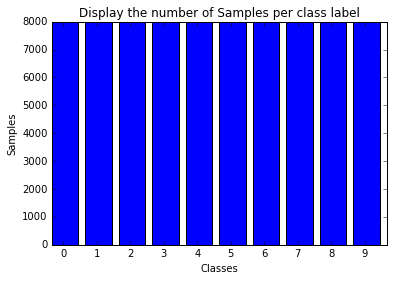

In [17]:
print "New dataset and labels shape:", dataset.shape, labels.shape 
display_data_distribution(labels.reshape(labels.shape[0]))

Now, after all this processing, it is important to make sure the images are still consistent.

In [18]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(3, 3, figsize=(8,8))
    
    for i in range(3):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            axarr[i, j].imshow(dataset[img_rand_index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Class Label: ' + str(labels[img_rand_index]))

    plt.show()

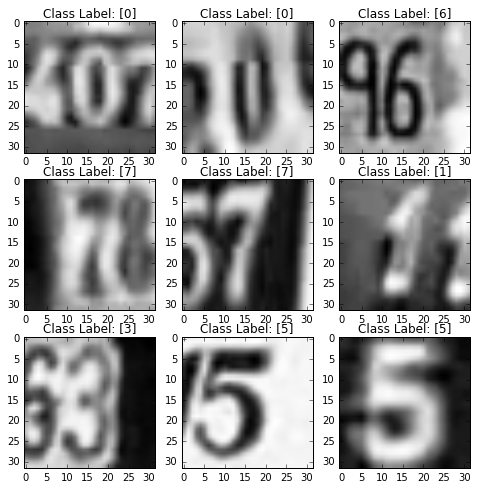

In [26]:
display_images_at_random(dataset, labels)

Let's also make sure that after normization, the images have the mean and the variance close to 0.

Image label: [9]
Mean: 0.0416855
Standard deviation: 0.126542


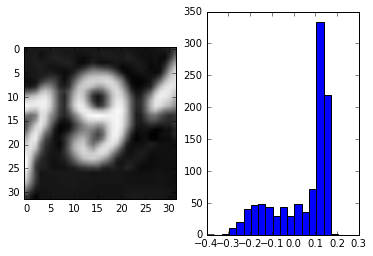

In [20]:
rand_img_index = random.randrange(0,labels.shape[0])
img = dataset[rand_img_index]

# display the normalized image
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap=plt.cm.Greys);
ax2.hist(img.reshape(IMAGE_SIZE*IMAGE_SIZE), bins=20, range=[np.min(img) - 0.1, np.max(img) + 0.1]);
print "Image label:", labels[rand_img_index]
print "Mean:", np.mean(img)
print "Standard deviation:", np.std(img)

Now let's make sure that our testing set also gets normilized and greyscaled to match the training data.

In [21]:
testing_dataset = np.zeros(shape=(test_labels.shape[0], IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)

test_index = 0
for img_index in range(0,test_labels.shape[0]):
    current_img = test_dataset[:,:,:,img_index]
    current_img = rgb2gray(current_img)
    current_img = (current_img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
    testing_dataset[test_index,:,:,:] = current_img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)
    test_index += 1
print "Done"

Done


Print some of the testing images and labels to see that everything is fine.

Test dataset and labels shape: (26032, 32, 32, 1) (26032, 1)


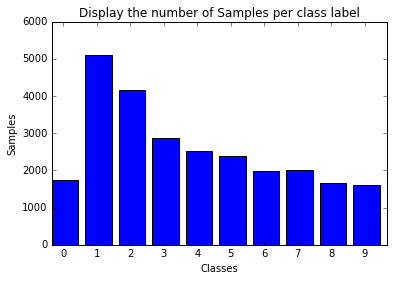

In [22]:
print "Test dataset and labels shape:", testing_dataset.shape, test_labels.shape 
display_data_distribution(test_labels.reshape(test_labels.shape[0]))

In [23]:
%xdel test_dataset

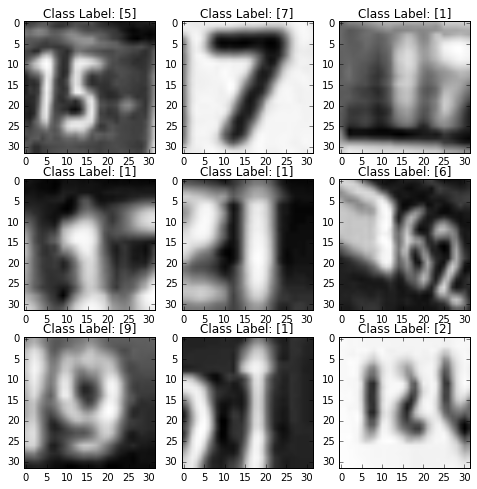

In [24]:
display_images_at_random(testing_dataset, test_labels)

Image label: [4]
Mean: -0.0287133
Standard deviation: 0.068899


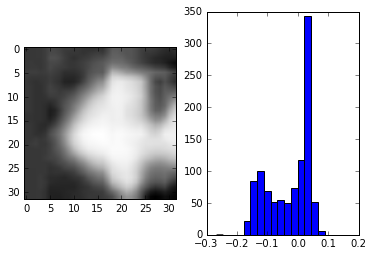

In [25]:
rand_img_index = random.randrange(0,test_labels.shape[0])
img = testing_dataset[rand_img_index]

# display the normalized image
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap=plt.cm.Greys);
ax2.hist(img.reshape(IMAGE_SIZE*IMAGE_SIZE), bins=20, range=[np.min(img) - 0.1, np.max(img) + 0.1]);
print "Image label:", test_labels[rand_img_index]
print "Mean:", np.mean(img)
print "Standard deviation:", np.std(img)

Now lets build train, test and validation datasets.

In [28]:
from sklearn.cross_validation import train_test_split

labels = labels.reshape(labels.shape[0])

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(
         dataset, labels, test_size=VALIDATION_DATASET_SIZE, random_state=42, stratify=labels)

In [29]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', testing_dataset.shape, test_labels.shape)

('Training set', (75000, 32, 32, 1), (75000,))
('Validation set', (5000, 32, 32, 1), (5000,))
('Test set', (26032, 32, 32, 1), (26032, 1))


Now save the dataset.

In [30]:
pickle_file = 'dataset.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': testing_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [31]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 434413591
